# Seminar Code
In this seminar, I talk about ICA-AROMA and Modular Preprocessing, what they are and how they transform our data in good and/or bad ways.
Many of the figures used in the presentation were generated in here.

In [24]:
# make the images appear inline (in the notebook)
%matplotlib inline

# import many of the basic packages necessary for the demonstrations/visualizations
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.formula.api as smf
from nipype.interfaces.afni.preprocess import TCorr1D

# change settings for graphs so they look better on a dark background
sns.set_palette('bright')
plt.style.use('ggplot')
plt.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color': "white",
                     'ytick.color': "white"})

## ICA-AROMA Example
In the following cells I will load in the results of a spatial ICA example on fmri data (data generated via [melodic](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC)). 
- First, I will demonstrate that the timeseries generated by spatial ICA are not independent of each other (as opposed to temporal ICA).
- Second, I will denoise an example voxel (in the right insula) and visualize how denoising the voxel influences whole brain correlations.
    - I will both aggressive and non-aggressive methods to denoise.

In [2]:
# the melodic output giving each ICA timeseries
ica_ts = pd.read_csv('./data/test_bold_MELODICmix.tsv', sep='\t', header=None)
ica_ts.dropna(axis='columns', how='all', inplace=True)
ica_ts = ica_ts.add_prefix('comp_')
ica_ts.head()


,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,...,comp_63,comp_64,comp_65,comp_66,comp_67,comp_68,comp_69,comp_70,comp_71,comp_72
0,-0.758030,-1.186418,0.790879,-2.197487,1.143364,0.027185,-0.401727,-0.266738,-0.899754,2.957095,...,0.202970,-0.757285,0.580424,-2.170545,1.135138,1.185032,0.161144,-1.449952,-0.340129,3.207329
1,0.855021,1.225001,2.436515,-0.110996,-1.360332,-0.645831,0.705279,-0.529328,-0.961012,3.887399,...,-1.151278,-1.355444,0.157133,-1.456655,-1.614684,-0.420475,2.215335,-0.568601,-1.310884,-0.647429
2,-1.378687,-1.099753,0.282676,-1.600301,-0.390527,-0.477530,-0.573430,-0.526413,-1.896047,2.362592,...,-0.269990,0.657094,0.669171,-0.859728,0.482538,1.614340,-0.225722,-1.383938,1.844453,1.692464
3,3.310646,1.226795,2.549461,0.782276,-0.979568,0.248360,0.926625,-0.615597,-1.456201,3.235565,...,-0.873392,0.517578,0.564591,-1.450724,-1.293111,-1.069044,1.296962,-1.100991,1.450045,-0.018287
4,-1.753966,-1.724009,-0.885913,-2.228024,0.471514,-0.653573,-1.937831,-0.583467,-1.993739,1.610389,...,-0.965310,-0.250692,1.413558,-0.252963,1.918096,1.726810,-0.392606,-1.935342,2.626670,1.386460


In [3]:
# load the noise indices
ica_noise_idx = np.loadtxt('./data/test_bold_AROMAnoiseICs.csv', delimiter=',', dtype='int')
ica_noise_idx -= 1
ica_noise_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35,
       36, 37, 38, 39, 41, 42, 43, 44, 48, 49, 50, 52, 53, 56, 58, 59, 60,
       61, 62, 64, 65, 66, 67, 69, 70, 72])

In [4]:
signal_noise_idx = np.full(len(ica_ts.columns), 'signal')
signal_noise_idx[ica_noise_idx] = 'noise'
signal_noise_idx


array(['noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'signal', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'noise', 'noise', 'signal', 'signal', 'signal', 'noise',
       'noise', 'noise', 'signal', 'noise', 'noise', 'signal', 'signal',
       'noise', 'signal', 'noise', 'noise', 'noise', 'noise', 'noise',
       'signal', 'noise', 'noise', 'noise', 'noise', 'signal', 'noise',
       'noise', 'signal', 'noise'], dtype='<U6')

In [5]:
# the noise and signal components aliased to different colors
color_idx = np.array([st.replace('noise', 'red').replace('signal', 'green') for st in signal_noise_idx])
color_idx

array(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'red', 'red', 'red', 'red', 'green', 'red', 'red', 'red', 'red',
       'green', 'green', 'green', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'green', 'red', 'green', 'red', 'red', 'red',
       'red', 'red', 'green', 'red', 'red', 'red', 'red', 'green', 'red',
       'red', 'green', 'red'], dtype='<U5')

In [6]:
# the confounds tsv
confounds = pd.read_csv('./data/test_bold_confounds.tsv', sep='\t')
confounds['FramewiseDisplacement'][0] = confounds['FramewiseDisplacement'][1:].mean()
confounds.head()

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,AROMAAggrComp61,AROMAAggrComp62,AROMAAggrComp63,AROMAAggrComp65,AROMAAggrComp66,AROMAAggrComp67,AROMAAggrComp68,AROMAAggrComp70,AROMAAggrComp71,AROMAAggrComp73
0,4.826616,0.244417,2.084664,NaN,NaN,NaN,0.390440,0.056869,-0.006587,-0.105907,...,1.977688,-0.869653,-1.181006,-0.757285,0.580424,-2.170545,1.135138,0.161144,-1.449952,3.207329
1,-1.675956,0.401133,0.607724,1.245240,10.564131,1.052146,0.619482,-0.001804,0.011459,-0.078431,...,0.173481,-0.326303,-0.542473,-1.355444,0.157133,-1.456655,-1.614684,2.215335,-0.568601,-0.647429
2,1.086976,0.593310,1.711596,1.329685,11.280532,1.202394,0.376306,0.035729,-0.029645,0.066901,...,1.663285,-1.108394,-2.723212,0.657094,0.669171,-0.859728,0.482538,-0.225722,-1.383938,1.692464
3,-0.268196,0.270533,0.871375,1.173665,9.956918,1.019827,0.207354,-0.000183,0.035827,-0.071468,...,-0.443019,1.377220,-0.745638,0.517578,0.564591,-1.450724,-1.293111,1.296962,-1.100991,-0.018287
4,1.103928,0.219790,1.583645,1.300516,11.033072,1.109406,0.497735,0.077244,-0.001720,-0.012880,...,1.480062,-2.249758,-1.405533,-0.250692,1.413558,-0.252963,1.918096,-0.392606,-1.935342,1.386460


In [7]:
# calculate correlations between all the components
correlations = np.corrcoef(ica_ts, rowvar=False)

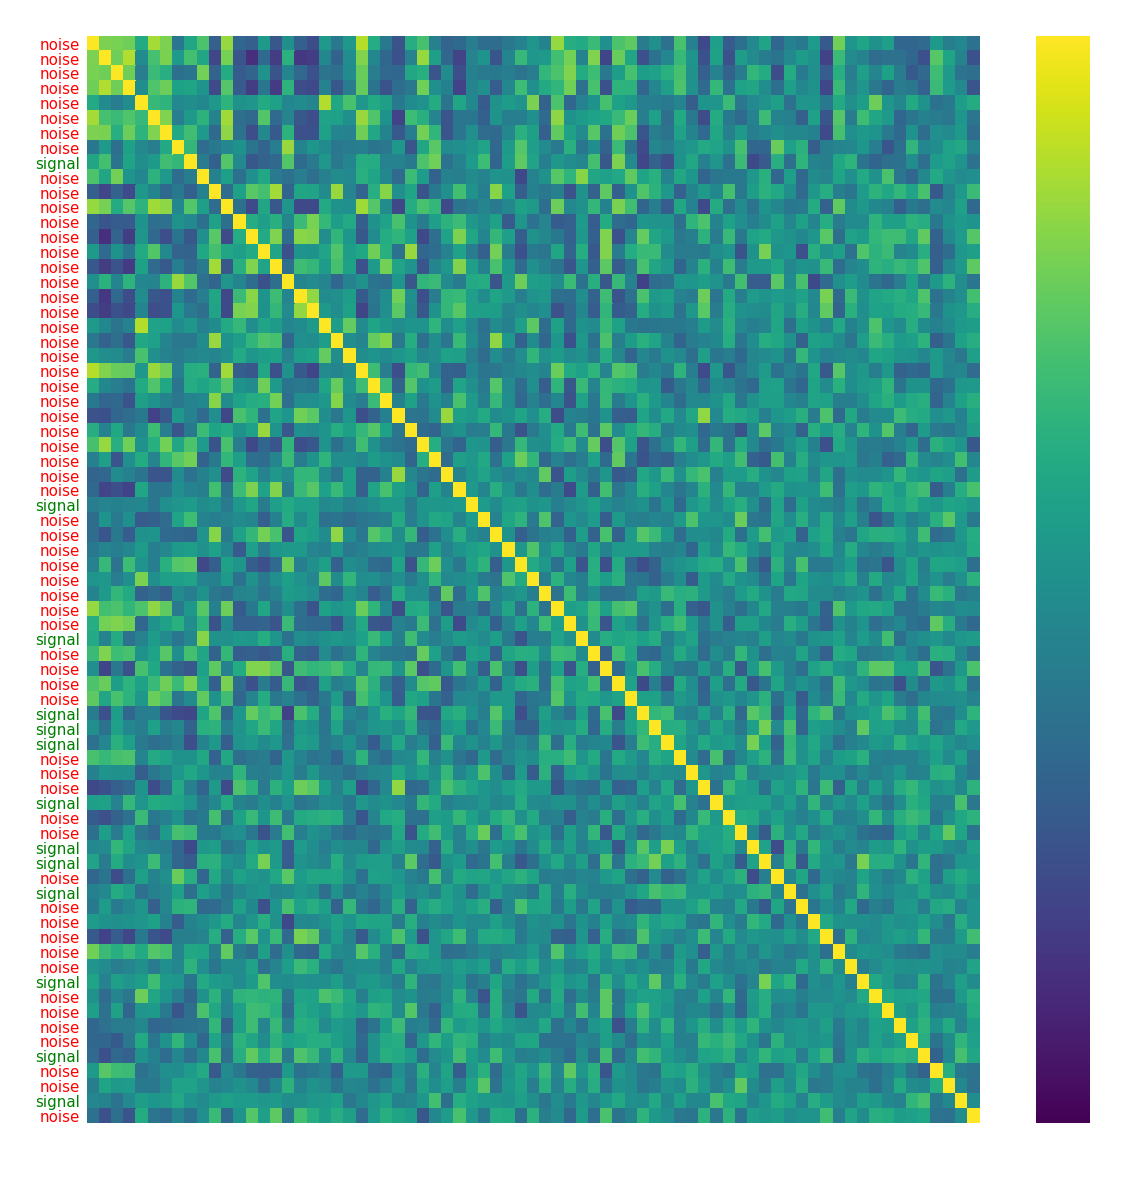

In [8]:
# visualize the components in a heatmap
# make the figure bigger overall
plt.rcParams["figure.figsize"] = (20,20)
fig = sns.heatmap(correlations, 
                  yticklabels=signal_noise_idx, #label the yaxis with individual markers
                  vmin=-1, vmax=1, # set the colorbar to go from -1 to 1
                  cmap='viridis') # have the color gradient go from red to blue
for color,tick in zip(color_idx, fig.yaxis.get_major_ticks()):
    tick.label1.set_color(color) # set the individual colors
    tick.label1.set_fontsize('15') # increase the size
fig.set_ylabel('Classification (Signal or Noise)', fontdict={'fontsize': 25})
fig.set_xlabel('ICA Component Number', fontdict={'fontsize': 25})
fig.set_title('Correlation of ICA Components', fontdict={'fontsize': 30})
plt.savefig('./imgs/correlation_ica_components.png', transparent=True)

In [9]:
# get a voxel in the right insula
bold_img = nib.load('./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
bold_data = bold_img.get_data()
right_insula = bold_data[37,44,19]
right_insula_df = pd.DataFrame.from_dict({'right_insula': right_insula})

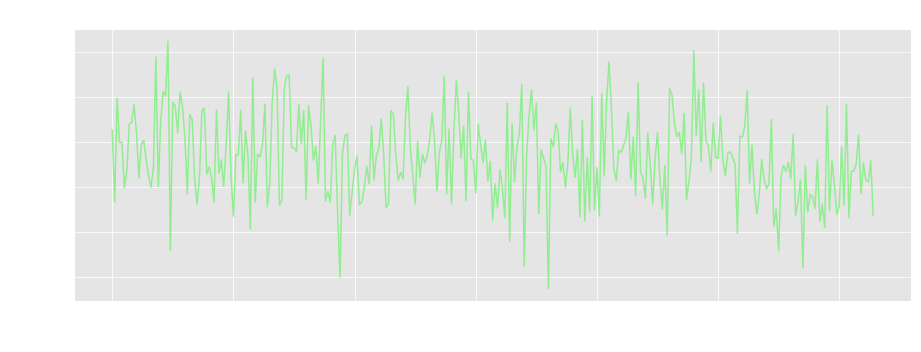

In [11]:
# plot out the right insula voxel
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["figure.figsize"] = (15, 5)
font = {'size': 15}

plt.rc('font', **font)
plt.plot(right_insula_df['right_insula'], color='lightgreen')
plt.title('right insula voxel')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Volumes)')
plt.savefig('./imgs/right_insula_timecourse.png', transparent=True)

In [19]:
# statsmodels (aggressive denoising)
column_names = ica_ts.iloc[:, ica_noise_idx].columns.tolist()
all_columns = "+".join(column_names)

model_agg = smf.ols('right_insula ~ ' + all_columns, 
                    data=pd.concat([ica_ts.iloc[:, ica_noise_idx], right_insula_df], axis='columns'))

In [20]:
fit_agg = model_agg.fit()

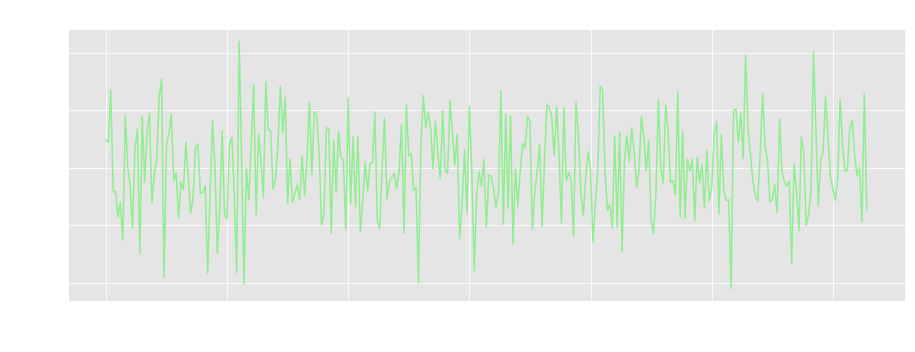

In [23]:
plt.plot(fit_agg.resid, color='lightgreen')
plt.title('right insula voxel (cleaned)')
plt.ylabel('Signal Intensity (AU)')
plt.xlabel('Time (Volumes)')
plt.savefig('./imgs/right_insula_timecourse_cleaned.png', transparent=True)

In [22]:
fit_agg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           right_insula   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     20.93
Date:                Tue, 25 Sep 2018   Prob (F-statistic):           6.78e-70
Time:                        11:37:24   Log-Likelihood:                -872.46
No. Observations:                 315   AIC:                             1867.
Df Residuals:                     254   BIC:                             2096.
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1056.5928      0.242   4362.098      0.000    1056.116    1057.070
comp_0         0.2291      0.794      0.288      0.773      -1.335       1.793
comp_1        -0.1159      1.043     -0.111      0.912      -2.170       1.938
comp_2        -0.5658      0.751     -0.753      0.452      -2.045       0.913
comp_3         0.8155      0.793      1.028      0.305      -0.747       2.378
comp_4        -2.3595      0.732     -3.222      0.001      -3.802      -0.917
comp_5         1.7459      0.670      2.607      0.010       0.427       3.065
comp_6         2.2821      0.627      3.642      0.000       1.048       3.516
comp_7         0.1947      0.588      0.331      0.741      -0.964       1.353
comp_9         0.5734      0.598      0.959      0.338      -0.604       1.751
comp_10       -0.0687      0.647     -0.106      0.916      -1.343       1.206
comp_11       -0.9683      0.720     -1.345      0.180      -2.386       0.449
comp_12        1.6330      0.553      2.951      0.003       0.543       2.723
comp_13       -1.7513      0.641     -2.733      0.007      -3.013      -0.489
comp_14        0.1853      0.673      0.275      0.783      -1.141       1.512
comp_15        1.2742      0.622      2.049      0.041       0.050       2.499
comp_16        0.5622      0.575      0.977      0.330      -0.571       1.696
comp_17       -1.0074      0.574     -1.756      0.080      -2.137       0.122
comp_18        6.7333      0.632     10.652      0.000       5.488       7.978
comp_19        1.3174      0.657      2.005      0.046       0.024       2.611
comp_20        1.5261      0.546      2.794      0.006       0.450       2.602
comp_21       -0.7698      0.489     -1.575      0.116      -1.732       0.193
comp_22       -0.8952      0.605     -1.480      0.140      -2.086       0.296
comp_23        1.8754      0.601      3.123      0.002       0.693       3.058
comp_24       -0.8081      0.481     -1.679      0.094      -1.756       0.140
comp_25        0.3265      0.569      0.574      0.566      -0.794       1.447
comp_26        0.3626      0.557      0.651      0.516      -0.735       1.460
comp_27       -1.8765      0.524     -3.582      0.000      -2.908      -0.845
comp_28       -0.4240      0.588     -0.722      0.471      -1.581       0.733
comp_29        1.0655      0.539      1.978      0.049       0.005       2.126
comp_30        0.4824      0.477      1.011      0.313      -0.457       1.422
comp_32       -0.0422      0.572     -0.074      0.941      -1.169       1.085
comp_33       -0.9046      0.543     -1.667      0.097      -1.973       0.164
comp_34       -0.0489      0.485     -0.101      0.920      -1.004       0.906
comp_35       -1.9147      0.548     -3.493      0.001      -2.994      -0.835
comp_36        0.1794      0.551      0.326      0.745      -0.906       1.265
co

In [16]:
# non-aggressive (you generate the betas for the noise components...
# while condsidering the variance that is explained by the signal components...
# then you subtract that "fitted" model from the original data
all_comps = '+'.join([str(x) for x in ica_ts.columns.tolist()])
model_noise = smf.ols('right_insula ~ ' + all_comps, data=pd.concat([ica_ts, right_insula_df], axis='columns'))
fit_noise = model_noise.fit()
noise_series = np.dot(ica_ts.iloc[:,ica_noise_idx], fit_noise.params[ica_noise_idx])
right_insula_nonaggr = right_insula_df['right_insula'] - noise_series

In [17]:
# write three text files for analysis
fit_agg.resid.to_csv('./data/right_insula-aggr.txt', index=False)
right_insula_df.to_csv('./data/right_insula-orig.txt', index=False, header=False)
right_insula_nonaggr.to_csv('./data/right_insula-nonaggr.txt', index=False)

In [25]:

afni_corr_objs = {}
for signal in ['orig', 'aggr', 'nonaggr']:
    # check to see if the file already exists (don't want people to have to install AFNI)
    if not os.path.isfile('./data/right_insula-{sig}_corr.nii.gz'.format(sig=signal)):
        afni_corr = TCorr1D(xset='./data/test_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
                            y_1d='./data/right_insula-{sig}.txt'.format(sig=signal),
                            args='-mask ./data/test_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
                            out_file='./data/right_insula-{sig}_corr.nii.gz'.format(sig=signal))
        res = afni_corr.run()
        afni_corr_objs[signal] = res.outputs.out_file


orig
aggr
nonaggr


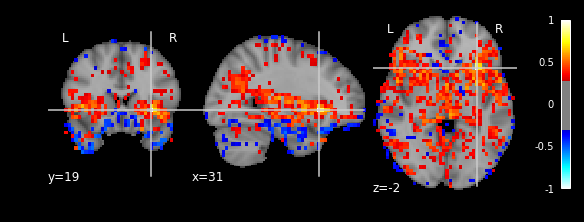

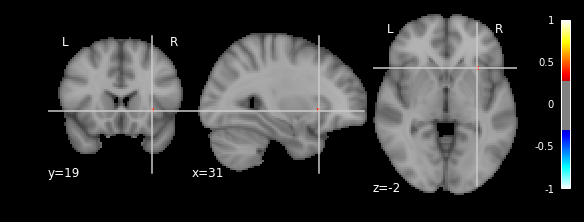

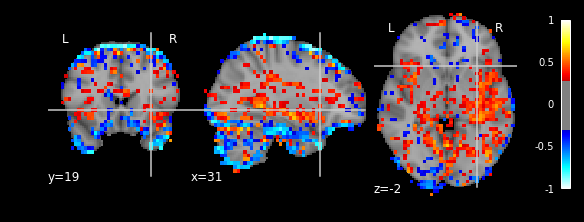

In [19]:
# plot the original correlation, the aggressive correlation...
# and the non-aggressive correlation
from nilearn.plotting import plot_stat_map
for signal, stat in afni_corr_objs.items():
    print(signal)
    plot_stat_map(stat, threshold=0.3, cut_coords=[31,19,-2], vmax=1.0, black_bg=True)
    plt.savefig('./imgs/{sig}_brain.png'.format(sig=signal), transparent=True)


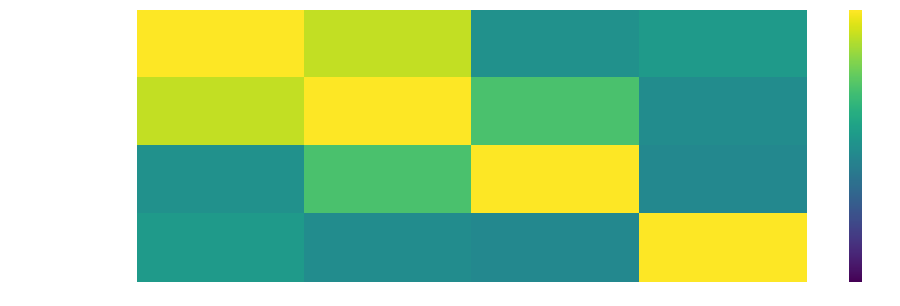

In [20]:
# see which denoising strategy still correlates with a measure of motion.
names = ['aggressive', 'original', 'nonaggressive']

sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['FramewiseDisplacement'].T), 
            yticklabels=names + ['FramewiseDisplacement'], # label the yaxis with individual markers
            xticklabels=names + ['FramewiseDisplacement'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap='viridis')

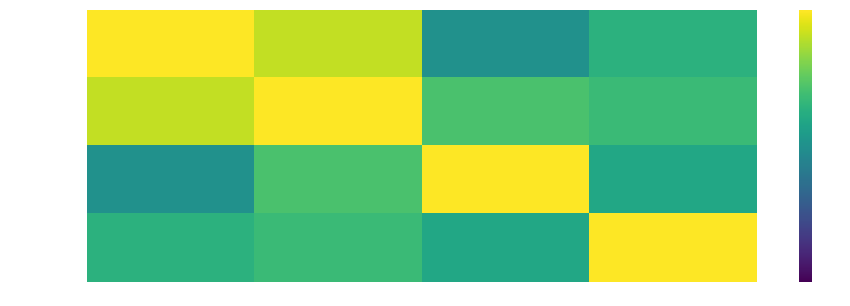

In [21]:
# see which measures correlate with the global signal
sns.heatmap(np.corrcoef(np.array([fit_agg.resid, right_insula_df['right_insula'], right_insula_nonaggr]), confounds['GlobalSignal'].T), 
            yticklabels=names + ['GlobalSignal'], # label the yaxis with individual markers
            xticklabels=names + ['GlobalSignal'],
            vmin=-0.5, vmax=0.5, # set the colorbar to go from -1 to 1
            center=0,
            cmap="viridis")

## Dummy ICA example
Copied from scikit learn's [website](http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html)

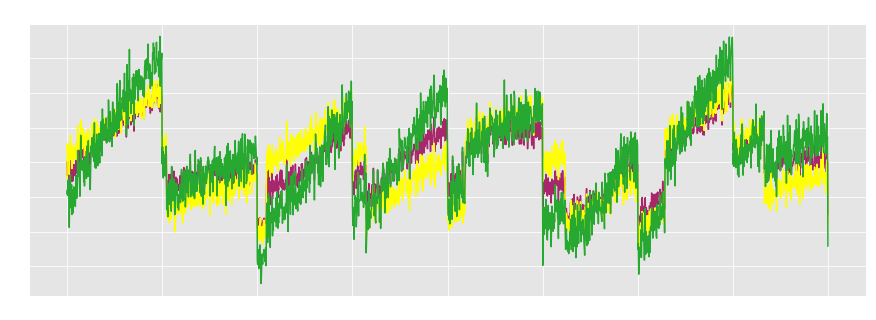

In [30]:
from scipy import signal

from sklearn.decomposition import FastICA, PCA
plt.rcParams["figure.figsize"] = (15,5)
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

plt.figure()

models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

plt.title(names[0])
for sig, color in zip(models[0].T, ['#a8276b', '#ffff00', '#27a830']):
    plt.plot(sig, color=color)
plt.savefig('./imgs/observations.png', transparent=True)

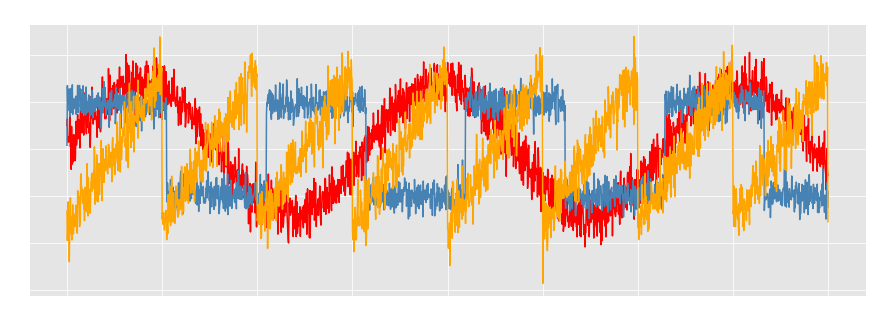

In [31]:
plt.figure()
plt.title(names[1])
for sig, color in zip(models[1].T, colors):
    plt.plot(sig, color=color)
plt.savefig('./imgs/true_sources.png', transparent=True)

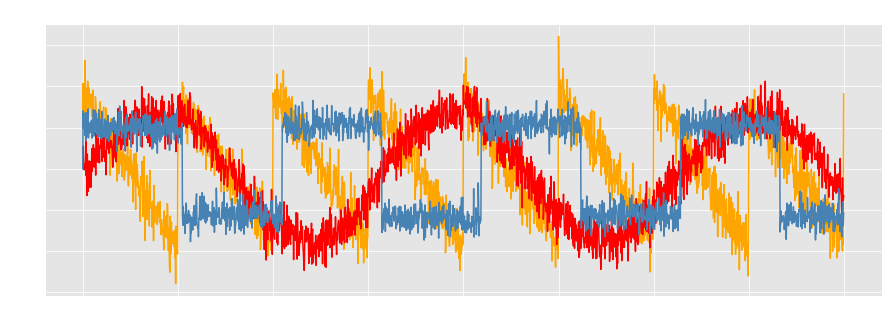

In [32]:
plt.figure()
plt.title(names[2])
for sig, color in zip(models[2].T, [colors[2], colors[0], colors[1]]):
    plt.plot(sig, color=color)
plt.savefig('./imgs/ica_recovered_signals.png', transparent=True)

## Venn Diagram
Visual demonstration of the shared noise between the components

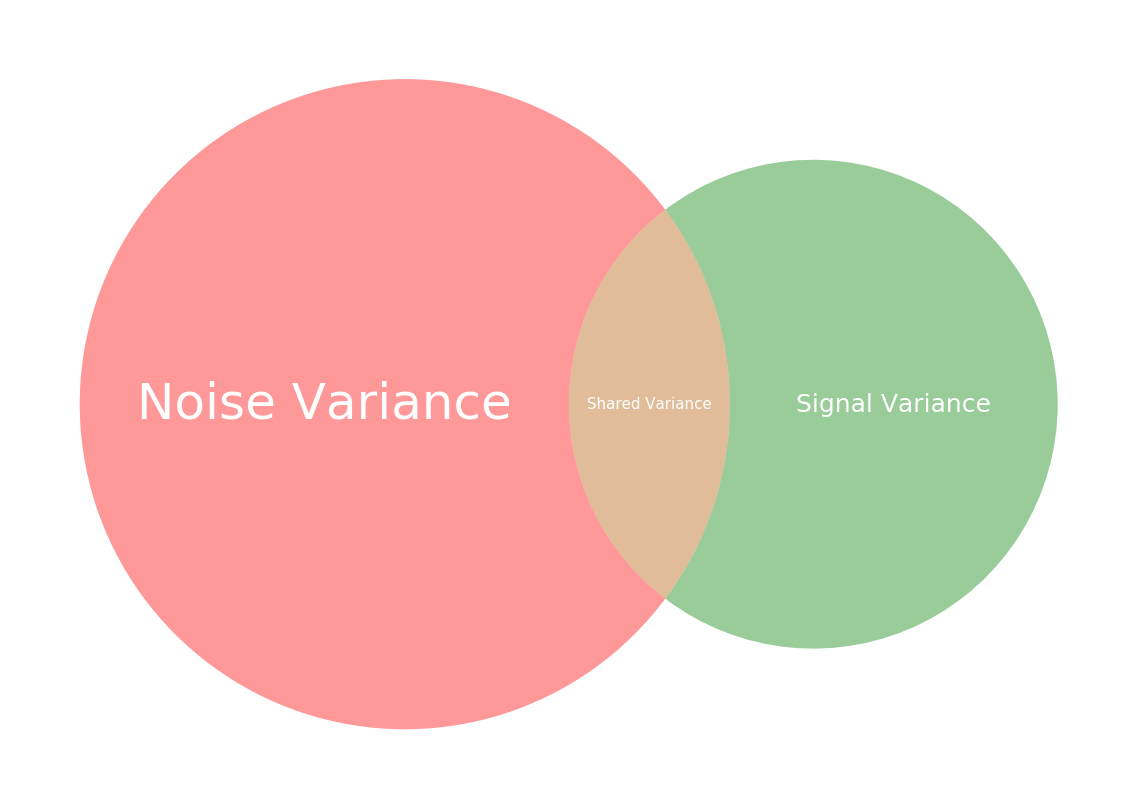

In [33]:
from matplotlib_venn import venn2
plt.rcParams["figure.figsize"] = (20, 20)
venn = venn2(subsets = {'10': 20, '01': 10, '11': 3}, set_labels=None)
venn.get_label_by_id('10').set_text('Noise Variance')
venn.get_label_by_id('10').set_size(50)
venn.get_label_by_id('01').set_text('Signal Variance')
venn.get_label_by_id('01').set_size(25)
venn.get_label_by_id('11').set_text('Shared Variance')
venn.get_label_by_id('11').set_size(15)
plt.savefig('./imgs/venn_diagram.png', transparent=True)
plt.show()

## Modular Preprocessing
Demonstrating that if confounds are not orthagonal and if you do a step by step regression, then you re-introduce correlations with your confounds.

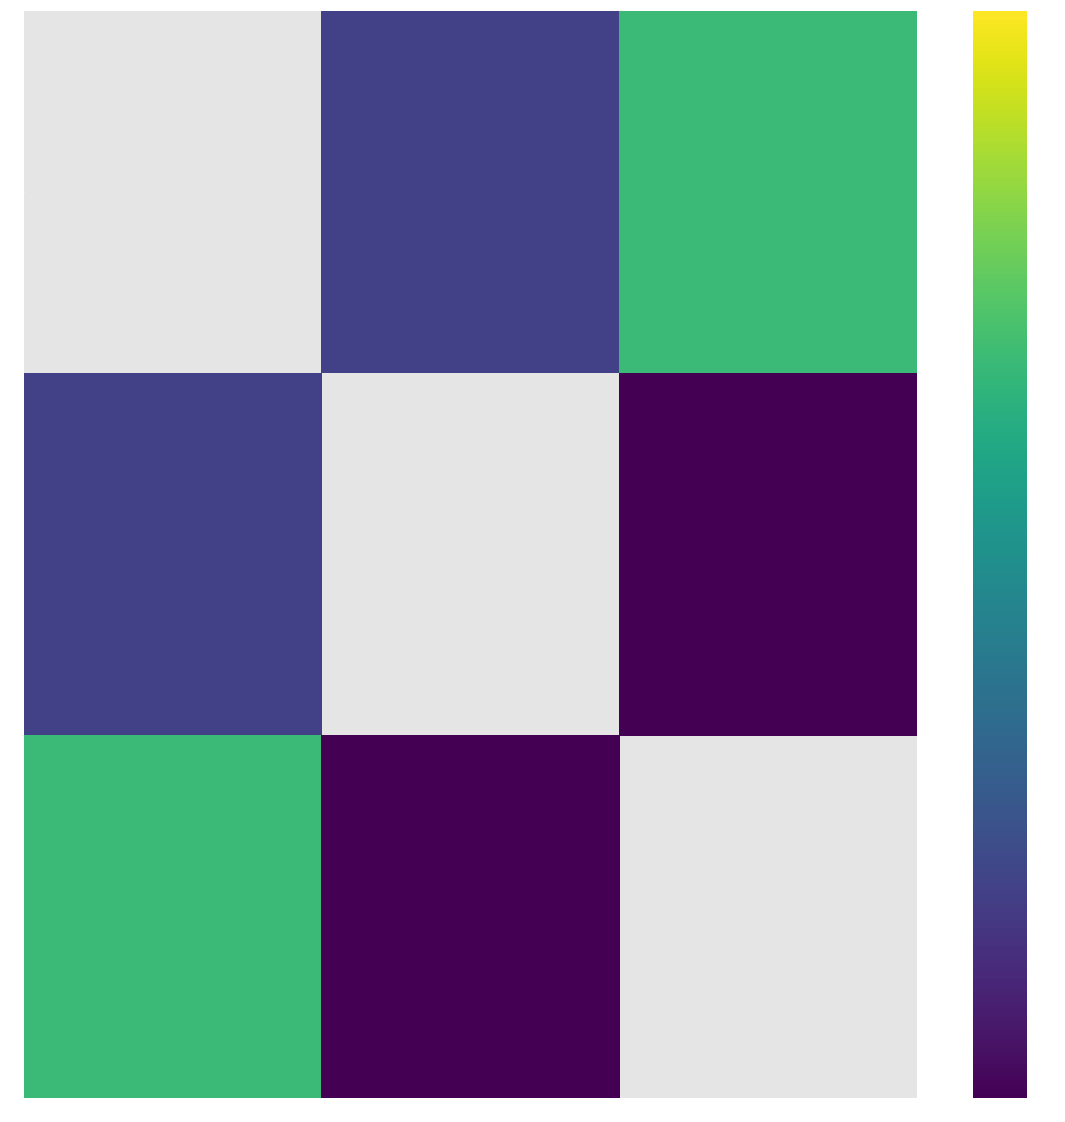

In [34]:
# right insula, motion (framewise displacement), and global signal
confound1 = confounds.aCompCor00
confound2 = confounds.GlobalSignal
modular_df = pd.concat([confound1, confound2, right_insula_df['right_insula']], axis='columns')
modular_df.columns = ['confound1', 'confound2', 'right_insula']
orig_corr = np.corrcoef([right_insula, confound1, confound2])
np.fill_diagonal(orig_corr, np.NaN)
sns.heatmap(orig_corr, vmin=-0.5, vmax=0.5, cmap='viridis')

In [35]:
# model confound1 then confound2
model_conf1 = smf.ols('right_insula ~ confound1', data=modular_df)
fit_conf1 = model_conf1.fit()
modular_df['right_insula_conf1'] = fit_conf1.resid
model_conf1_conf2 = smf.ols('right_insula_conf1 ~ confound2', data=modular_df)
fit_conf1_conf2 = model_conf1_conf2.fit()
modular_df['right_insula_conf1_conf2'] = fit_conf1_conf2.resid

# model confound2 then confound1
model_conf2 = smf.ols('right_insula ~ confound2', data=modular_df)
fit_conf2 = model_conf2.fit()
modular_df['right_insula_conf2'] = fit_conf2.resid
model_conf2_conf1 = smf.ols('right_insula_conf2 ~ confound1', data=modular_df)
fit_conf2_conf1 = model_conf2_conf1.fit()
modular_df['right_insula_conf2_conf1'] = fit_conf2_conf1.resid

# simultaneous
model_simult = smf.ols('right_insula ~ confound1 + confound2', data=modular_df)
fit_simult = model_simult.fit()
modular_df['right_insula_simult'] = fit_simult.resid

In [36]:
# original correlation
orig_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula']], rowvar=False)
# reintroduce correlations with confound1
conf1_conf2_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_conf1_conf2']], rowvar=False)
# reintroduce correlations with confound2
conf2_conf1_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_conf2_conf1']], rowvar=False)
# no correlations with confounds
simult_corr = np.corrcoef(modular_df[['confound1', 'confound2', 'right_insula_simult']], rowvar=False)
corrs = [orig_corr, conf1_conf2_corr, conf2_conf1_corr, simult_corr]

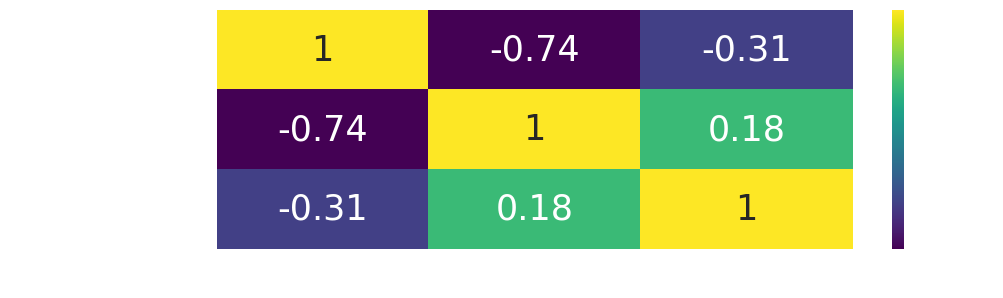

In [55]:
font = {'size': 35}

plt.rc('font', **font)

orig_corr_hm = sns.heatmap(corrs[0], vmin=-0.5, vmax=0.5, cmap='viridis', 
                           xticklabels=['confound1', 'confound2', 'right_insula'],
                           yticklabels=['confound1', 'confound2', 'right_insula'],
                           annot=True,
                           )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_orig.png', transparent='True')

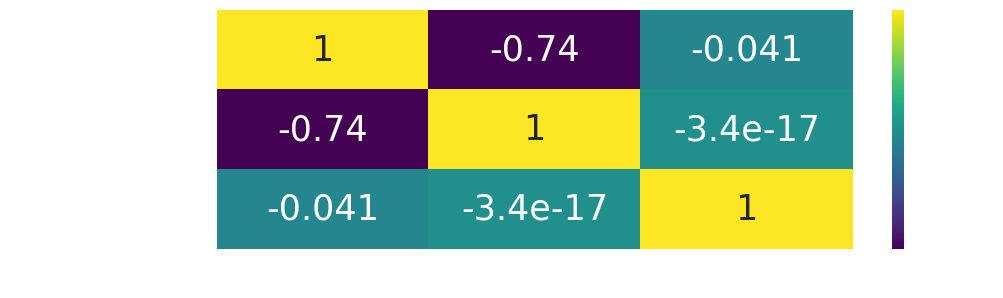

In [56]:
conf1_conf2_corr_hm = sns.heatmap(corrs[1], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'right_insula'],
                                  yticklabels=['confound1', 'confound2', 'right_insula'],
                                  annot=True,
                                  )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_conf1-conf2.png', transparent='True')

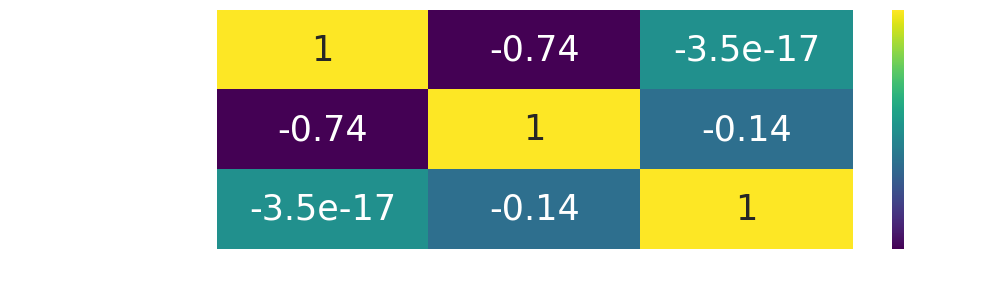

In [57]:
conf2_conf1_corr_hm = sns.heatmap(corrs[2], vmin=-0.5, vmax=0.5, cmap='viridis', 
                                  xticklabels=['confound1', 'confound2', 'right_insula'],
                                  yticklabels=['confound1', 'confound2', 'right_insula'],
                                  annot=True,
                                  )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_conf2-conf1.png', transparent='True')

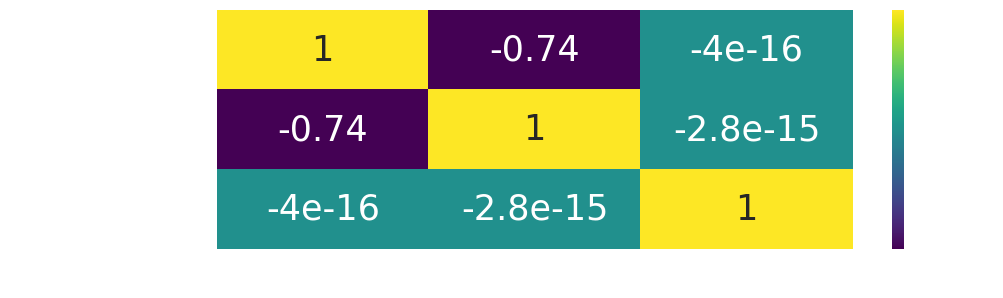

In [58]:
simult_corr_hm = sns.heatmap(corrs[3], vmin=-0.5, vmax=0.5, cmap='viridis', 
                             xticklabels=['confound1', 'confound2', 'right_insula'],
                             yticklabels=['confound1', 'confound2', 'right_insula'],
                             annot=True,
                             )
plt.tight_layout()
plt.savefig('./imgs/hm-corr_simult.png', transparent='True')